In [3]:
!pip install pmdarima

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

In [4]:
train_data = pd.read_csv('/content/Electric_Production_Train.csv')

train_data['DATE'] = pd.to_datetime(train_data['DATE'])
train_data.set_index('DATE', inplace=True)

train_data.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
test_data = pd.read_csv('/content/Electric_Production_Test.csv')

test_data['DATE'] = pd.to_datetime(test_data['DATE'])
test_data.set_index('DATE', inplace=True)

test_data.head()

,Value
DATE,
2014-01-01,124.2549
2014-02-01,112.8811
2014-03-01,104.7631
2014-04-01,90.2867
2014-05-01,92.1340


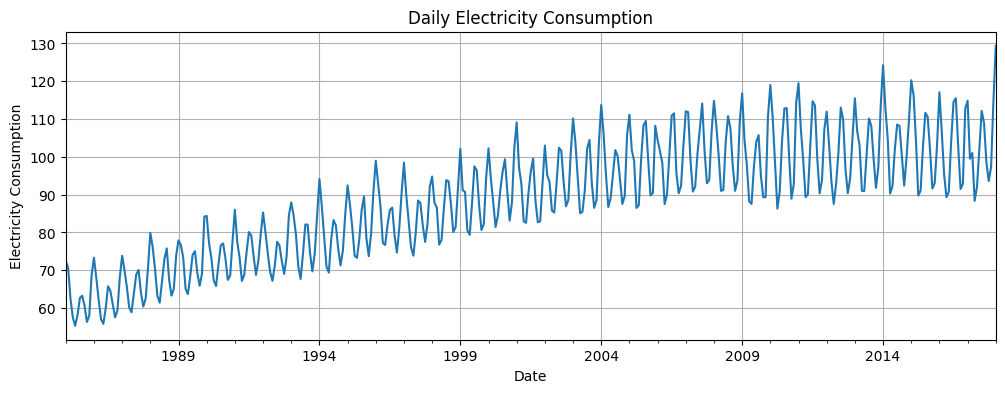

In [6]:
plt.figure(figsize=(12, 4))
train_data['Value'].plot(title='Daily Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.grid(True)
plt.show()

In [7]:
monthly_train_data = train_data['Value'].resample('M').mean()

monthly_test_data = test_data['Value'].resample('M').mean()

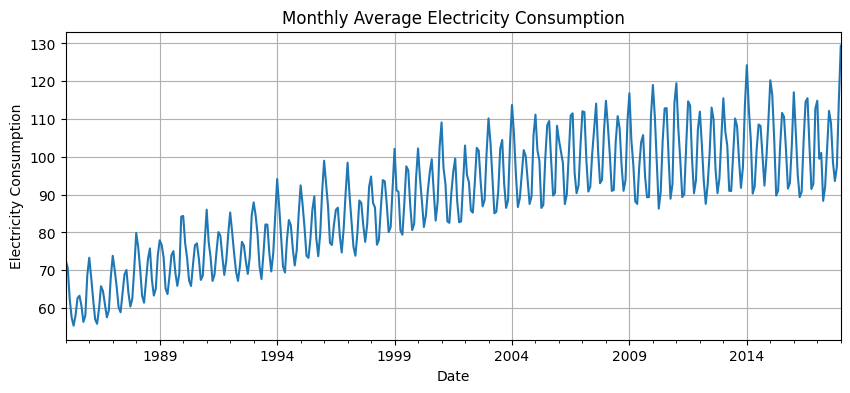

In [8]:
plt.figure(figsize=(10, 4))
monthly_train_data.plot(title='Monthly Average Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.grid(True)
plt.show()

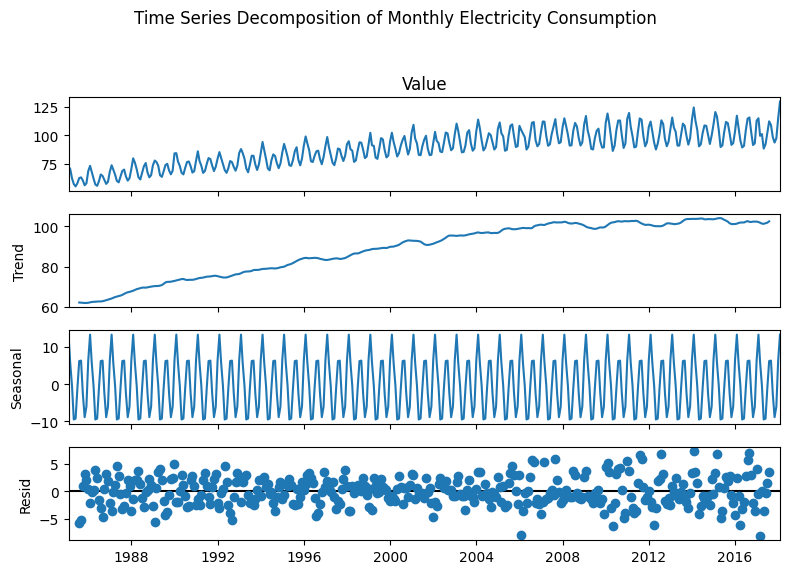

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(monthly_train_data, model='additive')

fig = decomposition.plot()
fig.set_size_inches(8, 6)
plt.suptitle('Time Series Decomposition of Monthly Electricity Consumption')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_train_data)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'Results: {result}')
print()

print(f'ADF Statistic: {adf_statistic}')
print(f'p-values: {p_value}')
print('Critical Values:')
print(f'  1%: {critical_values["1%"]}')
print(f'  5%: {critical_values["5%"]}')
print(f'  10%: {critical_values["10%"]}')

Results: (-2.256990350047235, 0.1862146911658712, 15, 381, {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}, 1840.8474501627156)

ADF Statistic: -2.256990350047235
p-values: 0.1862146911658712
Critical Values:
  1%: -3.4476305904172904
  5%: -2.869155980820355
  10%: -2.570827146203181


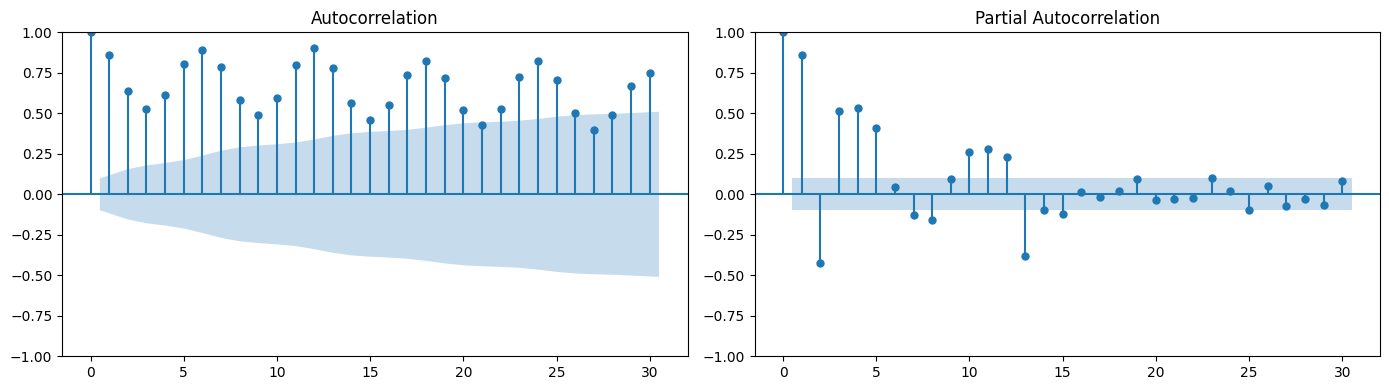

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(monthly_train_data, lags=30, ax=ax[0])

plot_pacf(monthly_train_data, lags=30, ax=ax[1])

plt.tight_layout()
plt.show()

In [12]:
import pmdarima as pm

arimamodel = pm.auto_arima(monthly_train_data,
                      seasonal=True, m=12,
                      start_p=0, start_q=0,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      trace=True,
                      stepwise=True,
                      error_action='ignore',
                      suppress_warnings=True)

print(arimamodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1947.697, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2750.050, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2401.309, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2748.185, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2453.328, Time=0.94 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1949.265, Time=5.74 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1948.983, Time=6.71 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2335.874, Time=2.43 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=15.84 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1937.907, Time=2.42 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2429.913, Time=0.83 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   :

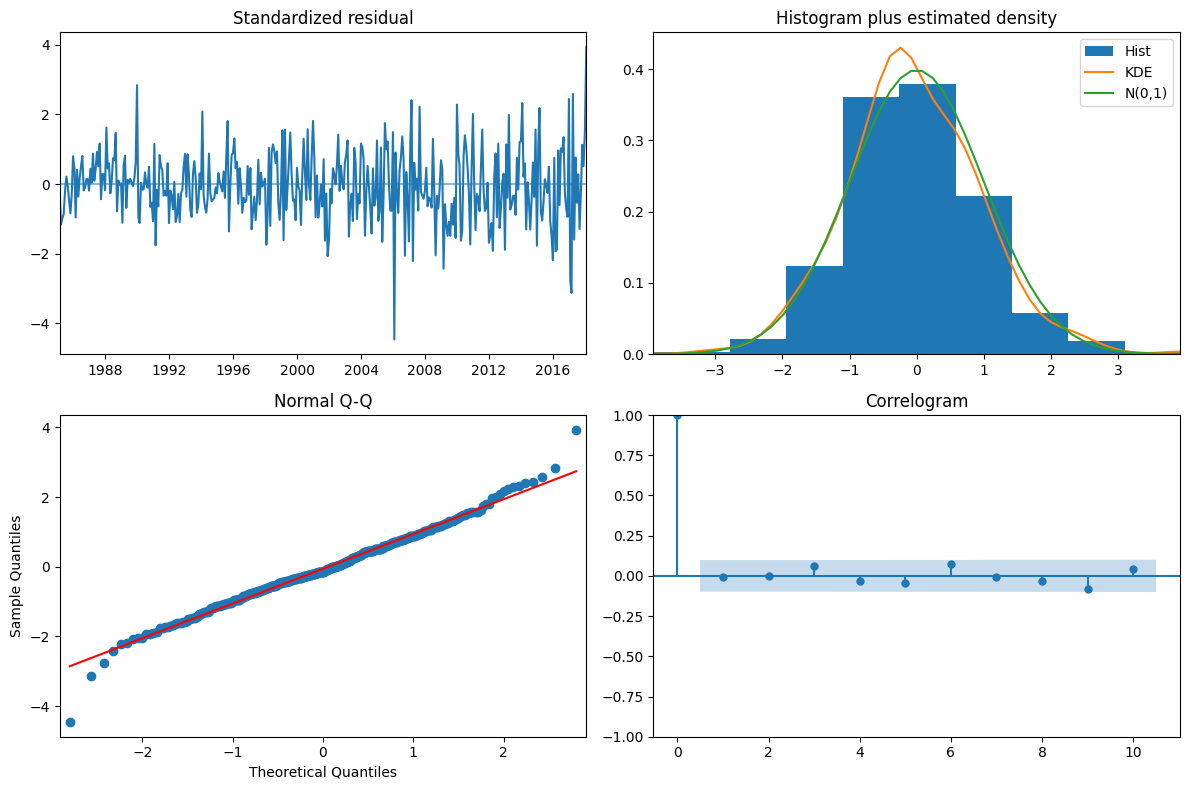

In [13]:
fig = arimamodel.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

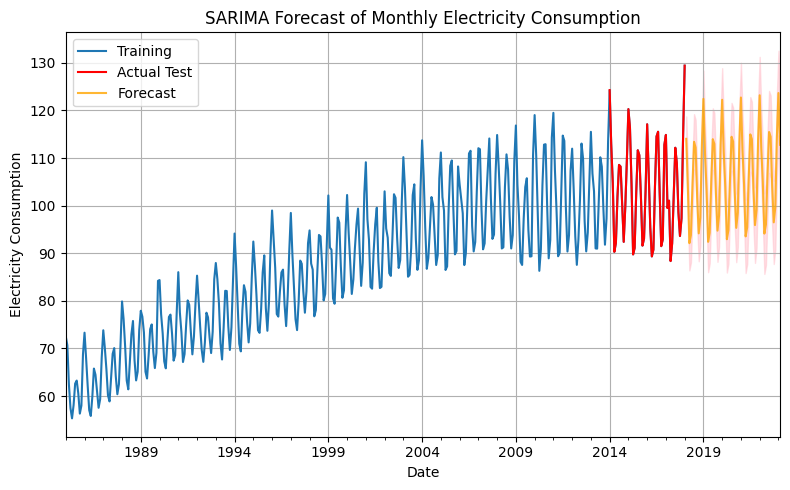

In [14]:
forecast_values, conf_int = arimamodel.predict(n_periods=len(monthly_test_data)+12, return_conf_int=True)

forecast_index = forecast_values.index

forecast_series = pd.Series(forecast_values, index=forecast_index)
lower_series = pd.Series(conf_int[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int[:, 1], index=forecast_index)

plt.figure(figsize=(8, 5))
monthly_train_data.plot(label='Training', legend=True)
monthly_test_data.plot(label='Actual Test', legend=True, color='red')
forecast_series.plot(label='Forecast', legend=True, color='orange', alpha=0.8)
plt.fill_between(forecast_index, lower_series, upper_series, color='pink', alpha=0.5)
plt.title('SARIMA Forecast of Monthly Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error

# Calculate the mean absolute error
mae = mean_absolute_error(monthly_test_data, forecast_values[:len(monthly_test_data)])

mae

8.93514663932019

In [16]:
rmse = sqrt(mean_squared_error(monthly_test_data, forecast_values[:len(monthly_test_data)]))

print('Test RMSE : %.3f' % rmse)

Test RMSE : 10.210
